# Fighting overfitting

In [ ]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F

from torchvision import models, datasets, transforms

In [ ]:
device = torch.device("cuda")

In [ ]:
hparams = {
    'batch_size':100,
    'num_epochs':12,
    'val_batch_size':100,
    'num_classes':10,
    'learning_rate':1e-3,
    'log_interval':100,
}

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)
])

train_dataset = datasets.CIFAR10("data", download=True, train=True, transform=transform)
test_dataset = datasets.CIFAR10("data", download=True, train=False, transform=transform)

train_dataset.data = train_dataset.data[:10000]
train_dataset.targets = train_dataset.targets[:10000]
test_dataset.data = test_dataset.data[:10000]
test_dataset.targets = test_dataset.targets[:10000]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, num_workers=4)
eval_loader = DataLoader(test_dataset, batch_size=hparams["val_batch_size"], shuffle=False, num_workers=4)


In [ ]:
import random
import matplotlib.pyplot as plt

def plot_samples(images,N=5):
    # Randomly select NxN images and save them in ps
    ps = random.sample(range(0,images.shape[0]), N**2)
    # Allocates figure f divided in subplots contained in an NxN axarr
    # https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.subplots.html
    f, axarr = plt.subplots(N, N)
    # Index for the images in ps to be plotted
    p = 0
    # Scan the NxN positions of the grid
    for i in range(N):
        for j in range(N):
          
            # Load the image pointed by p
            im = images[ps[p]].transpose(1,2,0)
            axarr[i,j].imshow(im)
            # Remove axis
            axarr[i,j].axis('off')
            # Point to the next image from the random selection
            p+=1
    # Show the plotted figure         
    plt.show()


Files already downloaded and verified


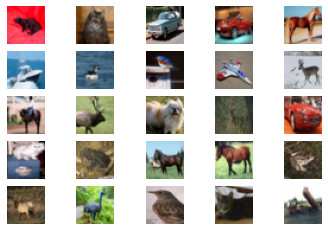

In [ ]:
sampleset = datasets.CIFAR10('data', train=True, download=True, 
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))
img = []
for n in range(50):
  img.append(sampleset[n][0][None, ...])
img = torch.cat(img, dim=0).data.numpy()
plot_samples(np.array(img))

In [ ]:
hparams["device"] = device


def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams, epoch):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  losses = []
  accs = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      acc = 100 * (correct_predictions(output, target) / data.shape[0])
      losses.append(loss.item())
      accs.append(acc)
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.1f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(),
              acc))
  return np.mean(losses), np.mean(accs)

def eval_epoch(val_loader, network, criterion, hparams):
    network.eval()
    device = hparams['device']
    eval_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in eval_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            eval_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    eval_loss /= len(eval_loader.dataset)
    eval_acc = 100. * acc / len(eval_loader.dataset)
    print('Eval set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        eval_loss, acc, len(eval_loader.dataset), eval_acc,
        ))
    return eval_loss, eval_acc


In [ ]:
def train_net(network, train_loader, optimizer, num_epochs, plot=True):
  """ Function that trains and evals a network for num_epochs,
      showing the plot of losses and accs and returning them.
  """
  tr_losses = []
  tr_accs = []
  te_losses = []
  te_accs = []

  network.to(hparams['device'])
  criterion = F.nll_loss

  for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_epoch(train_loader, network, optimizer, criterion, hparams, epoch)
    te_loss, te_acc = eval_epoch(eval_loader, network, criterion, hparams)
    te_losses.append(te_loss)
    te_accs.append(te_acc)
    tr_losses.append(tr_loss)
    tr_accs.append(tr_acc)
  rets = {'tr_losses':tr_losses, 'te_losses':te_losses,
          'tr_accs':tr_accs, 'te_accs':te_accs}
  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='train')
    plt.plot(te_losses, label='eval')
    plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Eval Accuracy [%]')
    plt.plot(tr_accs, label='train')
    plt.plot(te_accs, label='eval')
    plt.legend()
  return rets

In [ ]:
class ConvBlock(nn.Module):
    
    def __init__(self, num_imp_channels, num_out_fmaps, kernel_size, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(num_imp_channels, num_out_fmaps, kernel_size, stride)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return x


In [ ]:
class BigNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(3, 512, 3, stride=4)
        self.conv2 = ConvBlock(512, 1024, 3, stride=4)
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*2*2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.mlp(x)


In [ ]:
import torch.optim as optim

model = BigNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.729879	Acc: 42.0
Eval set: Average loss: 1.6381, Accuracy: 3930/10000 (39%)
Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.563240	Acc: 44.0
Eval set: Average loss: 1.5092, Accuracy: 4467/10000 (45%)
Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.321360	Acc: 54.0
Eval set: Average loss: 1.4584, Accuracy: 4803/10000 (48%)
Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.226609	Acc: 54.0
Eval set: Average loss: 1.4265, Accuracy: 4900/10000 (49%)
Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.144135	Acc: 58.0
Eval set: Average loss: 1.4941, Accuracy: 4811/10000 (48%)
Train Epoch: 6 [10000/10000 (100%)]	Loss: 0.934193	Acc: 68.0
Eval set: Average loss: 1.5078, Accuracy: 4971/10000 (50%)
Train Epoch: 7 [10000/10000 (100%)]	Loss: 0.620471	Acc: 77.0
Eval set: Average loss: 1.6391, Accuracy: 4905/10000 (49%)
Train Epoch: 8 [10000/10000 (100%)]	Loss: 0.335718	Acc: 85.0
Eval set: Average loss: 1.8193, Accuracy: 4875/10000 (49%)
Train Epoch: 9 [10000/10000 (100%)]	Loss

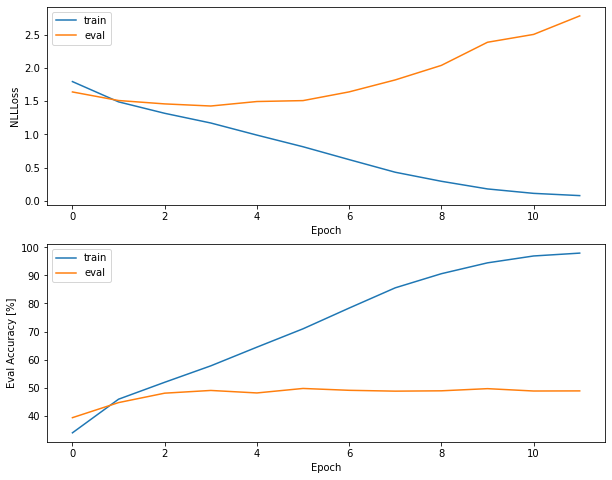

In [ ]:
bignet_log = train_net(model, train_loader, optimizer, hparams["num_epochs"], plot=True)

# Fighting Overfitting

1) Reduce the size of the model

In [ ]:
class SmallNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(3, 128, 3, stride=4)
        self.conv2 = ConvBlock(128, 256, 3, stride=4)
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*2*2, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.mlp(x)


In [ ]:
smallnet = SmallNet().to(device)
optimizer = optim.Adam(smallnet.parameters(), lr=hparams["learning_rate"])

Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.631009	Acc: 39.0
Eval set: Average loss: 1.6592, Accuracy: 4012/10000 (40%)
Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.432286	Acc: 48.0
Eval set: Average loss: 1.5663, Accuracy: 4252/10000 (43%)
Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.334149	Acc: 51.0
Eval set: Average loss: 1.5257, Accuracy: 4460/10000 (45%)
Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.279367	Acc: 55.0
Eval set: Average loss: 1.4572, Accuracy: 4726/10000 (47%)
Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.089717	Acc: 63.0
Eval set: Average loss: 1.4657, Accuracy: 4733/10000 (47%)
Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.179770	Acc: 53.0
Eval set: Average loss: 1.4294, Accuracy: 4913/10000 (49%)
Train Epoch: 7 [10000/10000 (100%)]	Loss: 1.048831	Acc: 56.0
Eval set: Average loss: 1.4755, Accuracy: 4906/10000 (49%)
Train Epoch: 8 [10000/10000 (100%)]	Loss: 0.791034	Acc: 74.0
Eval set: Average loss: 1.5254, Accuracy: 4913/10000 (49%)
Train Epoch: 9 [10000/10000 (100%)]	Loss

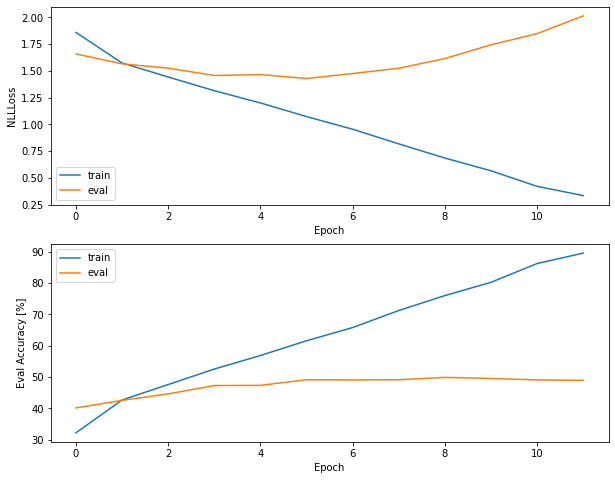

In [ ]:
smallnet_log = train_net(smallnet, train_loader, optimizer, hparams["num_epochs"], plot=True)

##Exercise 1: Adding L2 weight regularization

##Exercise 1: Adding L2 weight regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.


**TO DO:** In PyTorch, L2 weight regularization is added by controling the weight decay argument in the optimizer once this is built. Check the docs about the `Adam` optimizer and add build a `BigNet` where a `weight_decay` of 0.001 is applied (https://pytorch.org/docs/stable/optim.html#torch.optim.Adam). Then, train the model following the `train_net` function call, returning the value to the `bigmodel_l2_log` dictionary.

Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.721568	Acc: 38.0
Eval set: Average loss: 1.6373, Accuracy: 4054/10000 (41%)
Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.421171	Acc: 41.0
Eval set: Average loss: 1.5026, Accuracy: 4459/10000 (45%)
Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.425046	Acc: 47.0
Eval set: Average loss: 1.5111, Accuracy: 4493/10000 (45%)
Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.196044	Acc: 61.0
Eval set: Average loss: 1.4272, Accuracy: 4855/10000 (49%)
Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.393161	Acc: 45.0
Eval set: Average loss: 1.4107, Accuracy: 4906/10000 (49%)
Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.323242	Acc: 45.0
Eval set: Average loss: 1.4366, Accuracy: 4866/10000 (49%)
Train Epoch: 7 [10000/10000 (100%)]	Loss: 0.827424	Acc: 74.0
Eval set: Average loss: 1.4661, Accuracy: 4865/10000 (49%)
Train Epoch: 8 [10000/10000 (100%)]	Loss: 0.922943	Acc: 68.0
Eval set: Average loss: 1.5142, Accuracy: 4885/10000 (49%)
Train Epoch: 9 [10000/10000 (100%)]	Loss

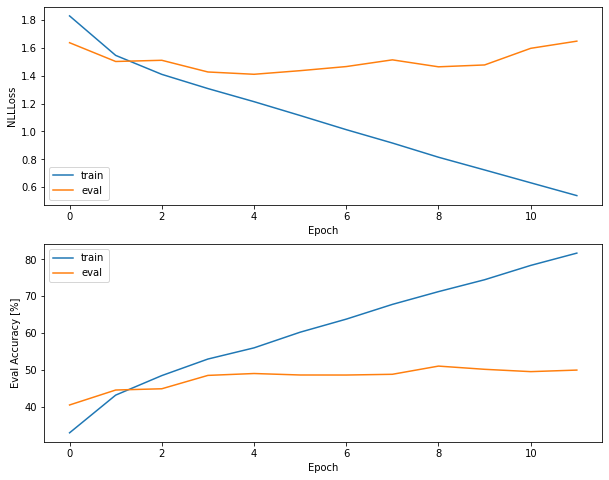

In [ ]:
# TO DO
bignet = BigNet()
optimizer = optim.Adam(bignet.parameters(), lr=hparams["learning_rate"], weight_decay=0.001)
bigmodel_l2_log = train_net(bignet, train_loader, optimizer, hparams["num_epochs"], plot=True)

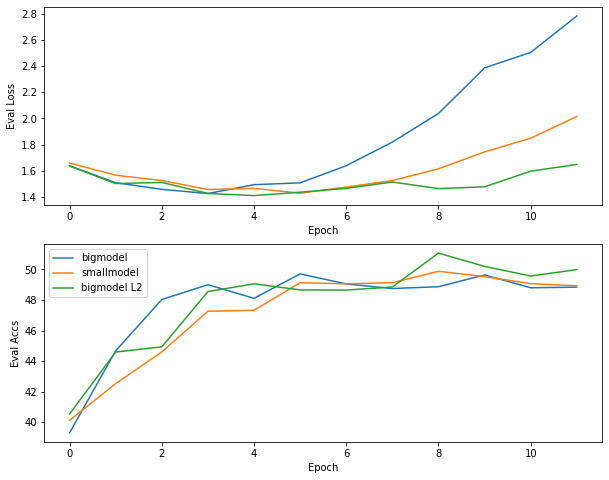

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bignet_log['te_losses'], label='bigmodel')
plt.plot(smallnet_log['te_losses'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_losses'], label='bigmodel L2')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.subplot(2,1,2)
plt.plot(bignet_log['te_accs'], label='bigmodel')
plt.plot(smallnet_log['te_accs'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_accs'], label='bigmodel L2')
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend();

# Adding dropout

## Exercise 2: Adding dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among other things, by a fraud prevention mechanism used by banks -- in his own words: "I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting".

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present.

**TO DO:**In PyTorch you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before it, e.g.:

`nn.Dropout(0.5)`. Make a `BigNetDropout` class that has the same network structure as in `BigNet`, and contains dropouts between each `ConvBlock` and in the middle of the `mlp` sub-network. The class has to accept an argument `dropout` that controls the amount of `Dropout` of the aforementioned layers.

In [ ]:
# TO DO
class BigNetDropout(nn.Module):

    def __init__(self, dropout):
        super().__init__()

        self.conv1 = ConvBlock(3, 512, 3, stride=4)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = ConvBlock(512, 1024, 3, stride=4)
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*2*2, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        return self.mlp(x)

Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.839664	Acc: 38.0
Eval set: Average loss: 1.6208, Accuracy: 4094/10000 (41%)
Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.480926	Acc: 46.0
Eval set: Average loss: 1.5286, Accuracy: 4356/10000 (44%)
Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.295050	Acc: 53.0
Eval set: Average loss: 1.4881, Accuracy: 4588/10000 (46%)
Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.442340	Acc: 43.0
Eval set: Average loss: 1.4179, Accuracy: 4872/10000 (49%)
Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.079451	Acc: 63.0
Eval set: Average loss: 1.4588, Accuracy: 4727/10000 (47%)
Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.126903	Acc: 59.0
Eval set: Average loss: 1.4447, Accuracy: 4888/10000 (49%)
Train Epoch: 7 [10000/10000 (100%)]	Loss: 0.995649	Acc: 63.0
Eval set: Average loss: 1.4710, Accuracy: 4963/10000 (50%)
Train Epoch: 8 [10000/10000 (100%)]	Loss: 0.893088	Acc: 66.0
Eval set: Average loss: 1.4970, Accuracy: 5023/10000 (50%)
Train Epoch: 9 [10000/10000 (100%)]	Loss

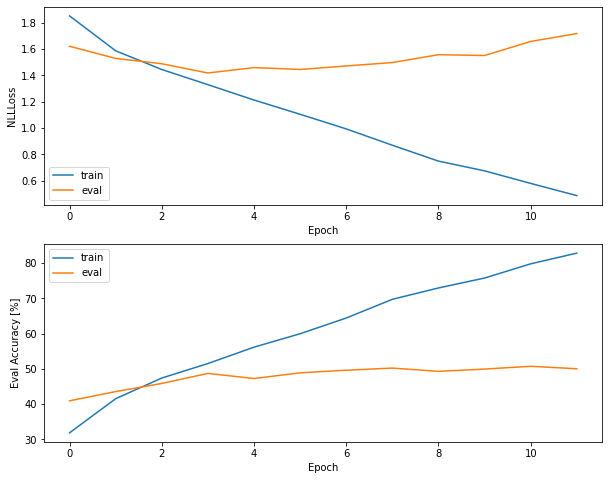

In [ ]:
dropout = 0.5
# TO DO
bignet_dropout = BigNetDropout(dropout).to(device)
optimizer = optim.Adam(bignet_dropout.parameters(), lr=hparams["learning_rate"])
bigmodel_dout_log = train_net(bignet_dropout, train_loader, optimizer, hparams["num_epochs"], plot=True)

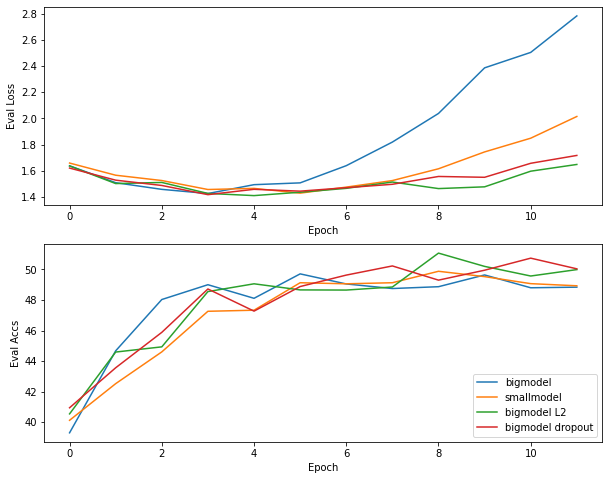

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bignet_log['te_losses'], label='bigmodel')
plt.plot(smallnet_log['te_losses'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_losses'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['te_losses'], label='bigmodel dropout')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.subplot(2,1,2)
plt.plot(bignet_log['te_accs'], label='bigmodel')
plt.plot(smallnet_log['te_accs'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_accs'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['te_accs'], label='bigmodel dropout')
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend();

## Exercise 3: Grand Finale

**Train the Big Model with Dropout on the whole CIFAR10 Dataset**, and then check the overlayed evaluation plots for the BigModel, the BigModel with Dropout, and this new BigModel with Dropout on the Big Trainset. To make the exercise follow the steps:

1. Defining the CIFAR dataset per se in training mode (look at the beginning of the notebook), but do NOT trim the `.data` and `.targets` lists.
2. Make the `DataLoader` out of the dataset.
3. Build the big network as shown before, with its optimizer, and call the training routine shown above, storing the results in the `bigmodel_bigtrainset_dout_log` dictionary.

Files already downloaded and verified
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.908809	Acc: 37.0
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.503140	Acc: 41.0
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.379910	Acc: 53.0
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.538846	Acc: 41.0
Train Epoch: 1 [50000/50000 (100%)]	Loss: 1.265834	Acc: 65.0
Eval set: Average loss: 1.3878, Accuracy: 4954/10000 (50%)
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.281969	Acc: 52.0
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.251274	Acc: 61.0
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.340396	Acc: 58.0
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.311180	Acc: 55.0
Train Epoch: 2 [50000/50000 (100%)]	Loss: 1.268933	Acc: 59.0
Eval set: Average loss: 1.3053, Accuracy: 5287/10000 (53%)
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.226404	Acc: 59.0
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.233472	Acc: 56.0
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.128482	Acc: 59.0
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.344519	Acc: 52.0
Tr

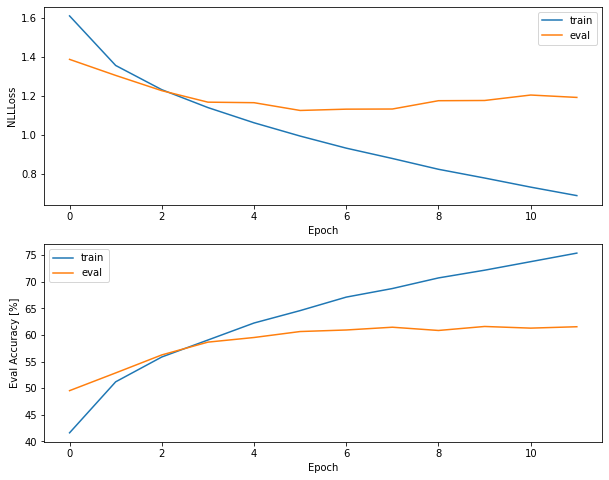

In [ ]:
# TO DO
big_trainset = datasets.CIFAR10("data", download=True, train=True, transform=transform)

big_loader = DataLoader(big_trainset, batch_size=hparams["batch_size"], shuffle=True, num_workers=4)

bignet = BigNetDropout(dropout).to(device)
optimizer = optim.Adam(bignet.parameters(), lr=hparams["learning_rate"])
bigmodel_bigtrainset_dout_log = train_net(bignet, big_loader, optimizer, hparams["num_epochs"], plot=True)


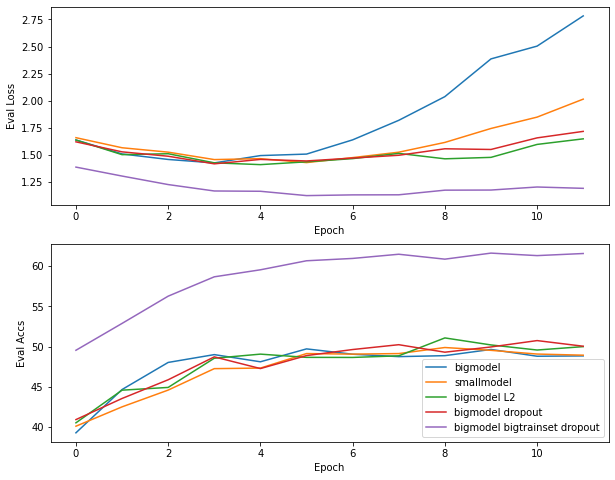

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bignet_log['te_losses'], label='bigmodel')
plt.plot(smallnet_log['te_losses'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_losses'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['te_losses'], label='bigmodel dropout')
plt.plot(bigmodel_bigtrainset_dout_log['te_losses'], label='bigmodel bigtrainset dropout')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.subplot(2,1,2)
plt.plot(bignet_log['te_accs'], label='bigmodel')
plt.plot(smallnet_log['te_accs'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_accs'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['te_accs'], label='bigmodel dropout')
plt.plot(bigmodel_bigtrainset_dout_log['te_accs'], label='bigmodel bigtrainset dropout')
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend();


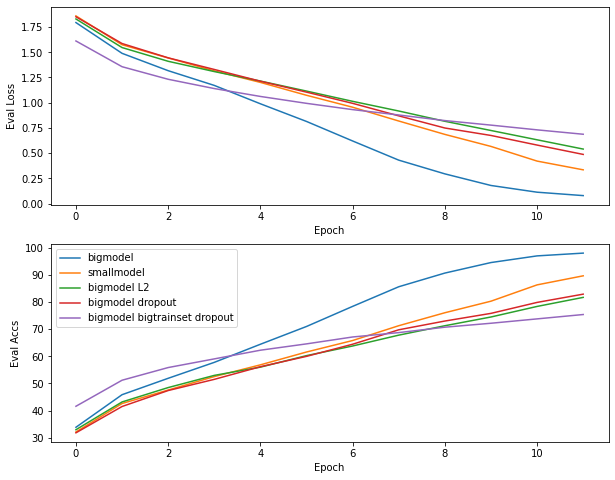

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bignet_log['tr_losses'], label='bigmodel')
plt.plot(smallnet_log['tr_losses'], label='smallmodel')
plt.plot(bigmodel_l2_log['tr_losses'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['tr_losses'], label='bigmodel dropout')
plt.plot(bigmodel_bigtrainset_dout_log['tr_losses'], label='bigmodel bigtrainset dropout')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.subplot(2,1,2)
plt.plot(bignet_log['tr_accs'], label='bigmodel')
plt.plot(smallnet_log['tr_accs'], label='smallmodel')
plt.plot(bigmodel_l2_log['tr_accs'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['tr_accs'], label='bigmodel dropout')
plt.plot(bigmodel_bigtrainset_dout_log['tr_accs'], label='bigmodel bigtrainset dropout')
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend();